# Install relevant packages

In [ ]:
!pip install tables==3.6.1
!pip install matplotsoccer

!pip install scikit-plot

!pip install socceraction==0.2.0
!pip install shap

     |████████████████████████████████| 4.3 MB 12.6 MB/s 
  Attempting uninstall: tables
    Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4
  Created wheel for matplotsoccer: filename=matplotsoccer-0.0.8-py3-none-any.whl size=5984 sha256=1284b8d4162cd426224bd699c8de2b585b9d9ec62c87b7bcbbe516d3e624421c
  Stored in directory: /root/.cache/pip/wheels/be/6f/64/335f5a5e7763b284f2f7d8893f20338de4d9f73794fe85ea7d
Successfully built matplotsoccer
     |████████████████████████████████| 241 kB 15.8 MB/s 
  Created wheel for socceraction: filename=socceraction-0.2.0-py3-none-any.whl size=30656 sha256=259c43c20b758803ba10064c0d8500cbc66613c590f9974206be8ecd3a853513
  Stored in directory: /root/.cache/pip/wheels/ad/b6/3c/8ae71bd96f4cc8ae86a4ee1fdbd7a6e29fc1e59cec98a543a6
Successfully built socceraction
     |████████████████████████████████| 356 kB 11.5 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64

# Mount google drive folder

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%mkdir -p '/content/gdrive/My Drive/PROJECT 2/'
%cd '/content/gdrive/My Drive/PROJECT 2/'

Mounted at /content/gdrive
/content/gdrive/My Drive/PROJECT 2


# Import libraries

In [ ]:
import warnings

import matplotsoccer
import numpy as np
import pandas as pd
from ipywidgets import fixed, interact_manual, widgets
from tqdm.notebook import tqdm

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from scikitplot.metrics import plot_calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier

In [ ]:
import shap
from socceraction.vaep.formula import value
from tqdm import tqdm
from xgboost import XGBClassifier, plot_importance

In [ ]:
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)

# Generate Features

## Load the dataset

In [ ]:
df_teams = pd.read_hdf('spadl.h5', key='teams')
df_players = pd.read_hdf('spadl.h5', key='players')
df_games = pd.read_hdf('spadl.h5', key='games')

In [ ]:
team_name_mapping = df_teams.set_index('team_id')['team_name'].to_dict()
df_games['home_team_name'] = df_games['home_team_id'].map(team_name_mapping)
df_games['away_team_name'] = df_games['away_team_id'].map(team_name_mapping)

## Explore SPADL actions

In [ ]:
df_games

,game_id,competition_id,season_id,game_date,home_team_id,away_team_id,home_team_name,away_team_name
0,2500089,364,181150,2018-05-13 14:00:00,1646,1659,Burnley FC,AFC Bournemouth
1,2500090,364,181150,2018-05-13 14:00:00,1628,1627,Crystal Palace FC,West Bromwich Albion FC
2,2500091,364,181150,2018-05-13 14:00:00,1673,1609,Huddersfield Town FC,Arsenal FC
3,2500092,364,181150,2018-05-13 14:00:00,1612,1651,Liverpool FC,Brighton & Hove Albion FC
4,2500093,364,181150,2018-05-13 14:00:00,1611,1644,Manchester United FC,Watford FC
...,...,...,...,...,...,...,...,...
375,2565552,795,181144,2017-08-19 20:15:00,680,691,Sevilla FC,Reial Club Deportiu Espanyol
376,2565551,795,181144,2017-08-19 18:15:00,756,679,Girona FC,Club Atlético de Madrid
377,2565549,795,181144,2017-08-19 16:15:00,692,687,Real Club Celta de Vigo,Real Sociedad de Fútbol
378,2565556,795,181144,2017-08-18 20:15:00,674,714,Valencia Club de Fútbol,UD Las Palmas


In [ ]:
df_games[(df_games['home_team_name'] == 'Manchester United FC') & 
         (df_games['away_team_name'] == 'Manchester City FC')]

,game_id,competition_id,season_id,game_date,home_team_id,away_team_id,home_team_name,away_team_name
220,2499873,364,181150,2017-12-10 16:30:00,1611,1625,Manchester United FC,Manchester City FC


In [ ]:
# Select a game of choice
game_id = 2499873

### Load SPADL actions for selected game

In [ ]:
with pd.HDFStore('spadl.h5') as spadlstore:
    df_actions = spadlstore[f'actions/game_{game_id}']
    df_actions = (
        df_actions.merge(spadlstore['actiontypes'], how='left')
        .merge(spadlstore['results'], how='left')
        .merge(spadlstore['bodyparts'], how='left')
        .merge(spadlstore['players'], how="left")
        .merge(spadlstore['teams'], how='left')
        .reset_index()
        .rename(columns={'index': 'action_id'})
    )

In [ ]:
# Look at first 5 actions of the match
df_actions[:5]

,action_id,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,bodypart_id,type_id,result_id,type_name,result_name,bodypart_name,short_name,first_name,last_name,birth_date,short_team_name,team_name
0,0,2499873.0,1.0,4.077411,1611.0,7934.0,52.50,34.00,24.15,43.52,0,0,1,pass,success,foot,J. Lingard,Jesse,Lingard,1992-12-15,Manchester United,Manchester United FC
1,1,2499873.0,1.0,7.135643,1611.0,101652.0,24.15,43.52,79.80,6.12,0,0,1,pass,success,foot,M. Rojo,Faustino Marcos Alberto,Rojo,1990-03-20,Manchester United,Manchester United FC
2,2,2499873.0,1.0,12.618250,1625.0,105339.0,90.30,3.40,68.25,14.28,0,0,0,pass,fail,foot,Fernandinho,Fernando Luiz,Rosa,1985-05-04,Manchester City,Manchester City FC
3,3,2499873.0,1.0,14.525614,1611.0,3413.0,68.25,14.28,70.35,26.52,0,0,0,pass,fail,foot,Ander Herrera,Ander,Herrera Agüera,1989-08-14,Manchester United,Manchester United FC
4,4,2499873.0,1.0,17.735636,1625.0,38021.0,70.35,26.52,65.10,64.60,0,0,1,pass,success,foot,K. De Bruyne,Kevin,De Bruyne,1991-06-28,Manchester City,Manchester City FC


In [ ]:
def nice_time(row):
    minute = int((row['period_id']>=2) * 45 + (row['period_id']>=3) * 15 + 
                 (row['period_id']==4) * 15 + row['time_seconds'] // 60)
    second = int(row['time_seconds'] % 60)
    return f'{minute}m{second}s'

df_actions['nice_time'] = df_actions.apply(nice_time,axis=1)

In [ ]:
def action_name(row):
    return f"{row['action_id']}: {row['nice_time']} - {row['short_name']} {row['type_name']}"

df_actions['action_name'] = df_actions.apply(action_name, axis=1)

In [ ]:
def plot_actions(df_actions_to_plot):
    matplotsoccer.actions(
        location=df_actions_to_plot[['start_x', 'start_y', 'end_x', 'end_y']],
        action_type=df_actions_to_plot['type_name'],
        team=df_actions_to_plot['team_name'],
        result=df_actions_to_plot['result_name'] == 'success',
        label=df_actions_to_plot[['nice_time', 'type_name', 'short_name', 'short_team_name']],
        labeltitle=['time', 'actiontype', 'player', 'team'],
        zoom=False,
        figsize=8)

In [ ]:
def plot_actions_from_action_name(df_actions, action_name):
    action_id = int(action_name.split(':')[0])
    df_actions_to_plot = df_actions[action_id-3: action_id+3]
    plot_actions(df_actions_to_plot)

In [ ]:
interact_manual(plot_actions_from_action_name, 
                df_actions = fixed(df_actions),
                action_name=widgets.Select(
                    size = 10,
                    options = df_actions['action_name'][3:],
                    disabled=False)
               )

interactive(children=(Select(description='action_name', options=('3: 0m14s - Ander Herrera pass', '4: 0m17s - …

<function __main__.plot_actions_from_action_name>

## Representing actions

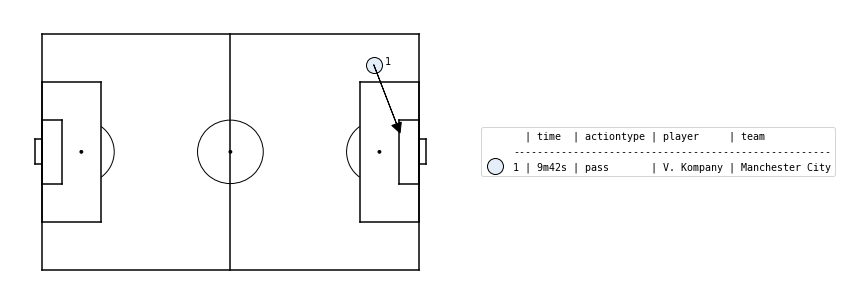

In [ ]:
action_id = 145
plot_actions(df_actions[action_id:action_id+1])

In [ ]:
df_actions[action_id:action_id+1].T

,145
action_id,145
game_id,2.49987e+06
period_id,1
time_seconds,582.313
team_id,1625
player_id,8307
start_x,92.4
start_y,59.16
end_x,99.75
end_y,39.44


### Representing locations

In [ ]:
PITCH_LENGTH = 105
PITCH_WIDTH = 68

In [ ]:
df_actions[action_id:action_id+1][['start_x', 'start_y', 'end_x', 'end_y']]

,start_x,start_y,end_x,end_y
145,92.4,59.16,99.75,39.44


In [ ]:
for side in ['start', 'end']:
    # Normalize the X location
    key_x = f'{side}_x'
    df_actions[f'{key_x}_norm'] = df_actions[key_x] / PITCH_LENGTH

    # Normalize the Y location
    key_y = f'{side}_y'
    df_actions[f'{key_y}_norm'] = df_actions[key_y] / PITCH_WIDTH

In [ ]:
df_actions[action_id:action_id+1][['start_x_norm', 'start_y_norm', 'end_x_norm', 'end_y_norm']]

,start_x_norm,start_y_norm,end_x_norm,end_y_norm
145,0.88,0.87,0.95,0.58


In [ ]:
GOAL_X = PITCH_LENGTH
GOAL_Y = PITCH_WIDTH / 2

In [ ]:
for side in ['start', 'end']:
    diff_x = GOAL_X - df_actions[f'{side}_x']
    diff_y = abs(GOAL_Y - df_actions[f'{side}_y'])
    df_actions[f'{side}_distance_to_goal'] = np.sqrt(diff_x ** 2 + diff_y ** 2)
    df_actions[f'{side}_angle_to_goal'] = np.divide(diff_x, diff_y, 
                                                    out=np.zeros_like(diff_x), 
                                                    where=(diff_y != 0))

In [ ]:
df_actions[action_id:action_id+1][['start_distance_to_goal', 'start_angle_to_goal', 'end_distance_to_goal', 'end_angle_to_goal']]

,start_distance_to_goal,start_angle_to_goal,end_distance_to_goal,end_angle_to_goal
145,28.138685,0.500795,7.560165,0.965074


In [ ]:
for side in ['start', 'end']:
    df_actions[f'{side}_is_penalty_box'] = ((df_actions[f'{side}_x'] > (PITCH_LENGTH-16.5)) & 
                                            (df_actions[f'{side}_y'] > (13.85)) & 
                                            (df_actions[f'{side}_y'] > (PITCH_WIDTH-13.85)))

In [ ]:
df_actions[action_id:action_id+1][['start_is_penalty_box', 'end_is_penalty_box']]

,start_is_penalty_box,end_is_penalty_box
145,True,False


### Representing body part, action type and result

In [ ]:
pd.get_dummies(df_actions['type_name'])

,clearance,corner_crossed,corner_short,cross,dribble,foul,freekick_crossed,freekick_short,goalkick,interception,keeper_save,pass,shot,shot_freekick,tackle,take_on,throw_in
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1275,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1276,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1277,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
def add_action_type_dummies(df_actions):
    return df_actions.merge(pd.get_dummies(df_actions['type_name']), how='left',
                             left_index=True, right_index=True)

In [ ]:
df_actions = add_action_type_dummies(df_actions)

In [ ]:
df_actions[action_id:action_id+1]

,action_id,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,bodypart_id,type_id,result_id,type_name,result_name,bodypart_name,short_name,first_name,last_name,birth_date,short_team_name,team_name,nice_time,action_name,start_x_norm,start_y_norm,end_x_norm,end_y_norm,start_distance_to_goal,start_angle_to_goal,end_distance_to_goal,end_angle_to_goal,start_is_penalty_box,end_is_penalty_box,clearance,corner_crossed,corner_short,cross,dribble,foul,freekick_crossed,freekick_short,goalkick,interception,keeper_save,pass,shot,shot_freekick,tackle,take_on,throw_in
145,145,2499873.0,1.0,582.313165,1625.0,8307.0,92.4,59.16,99.75,39.44,0,0,1,pass,success,foot,V. Kompany,Vincent,Kompany,1986-04-10,Manchester City,Manchester City FC,9m42s,145: 9m42s - V. Kompany pass,0.88,0.87,0.95,0.58,28.138685,0.500795,7.560165,0.965074,True,False,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
df_actions['bodypart_name'].unique()

array(['foot', 'head', 'other'], dtype=object)

In [ ]:
df_actions['result_name'].unique()

array(['success', 'fail', 'offside'], dtype=object)

In [ ]:
df_actions[action_id:action_id+1][['bodypart_name', 'result_name']]

,bodypart_name,result_name
145,foot,success


### Determine distance covered in x, y and total time played

In [ ]:
def add_distance_features(df_actions):
    df_actions['diff_x'] = df_actions['end_x'] - df_actions['start_x']
    df_actions['diff_y'] = df_actions['end_y'] - df_actions['start_y']
    df_actions['distance_covered'] = np.sqrt((df_actions['end_x'] - df_actions['start_x']) ** 2 +
                                             (df_actions['end_y'] - df_actions['start_y']) ** 2)

In [ ]:
def add_time_played(df_actions):
    df_actions['time_played'] = (df_actions['time_seconds'] + 
                             (df_actions['period_id'] >= 2) * (45 * 60) + 
                             (df_actions['period_id'] >= 3) * (15 * 60) + 
                             (df_actions['period_id'] == 4) * (15 * 60)
                             )

In [ ]:
add_distance_features(df_actions)
add_time_played(df_actions)

In [ ]:
df_actions[action_id:action_id+1][['diff_x', 'diff_y', 'distance_covered', 'time_played']]

,diff_x,diff_y,distance_covered,time_played
145,7.35,-19.72,21.045211,582.313165


## Representing game states

### Representing actions leading to game state

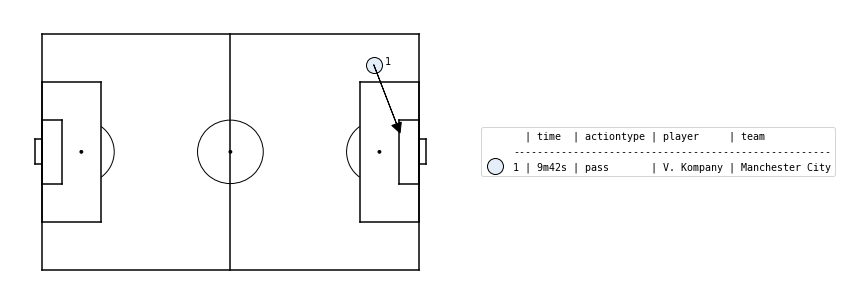

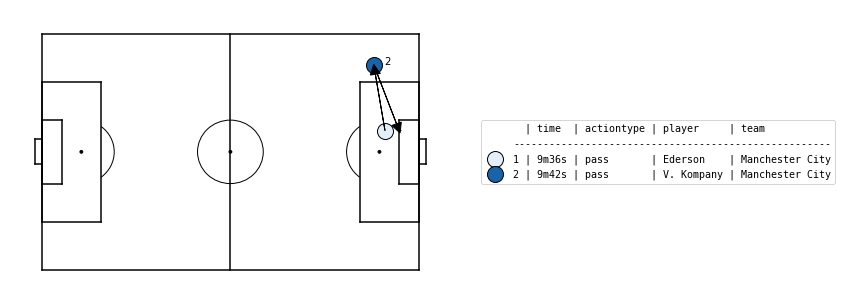

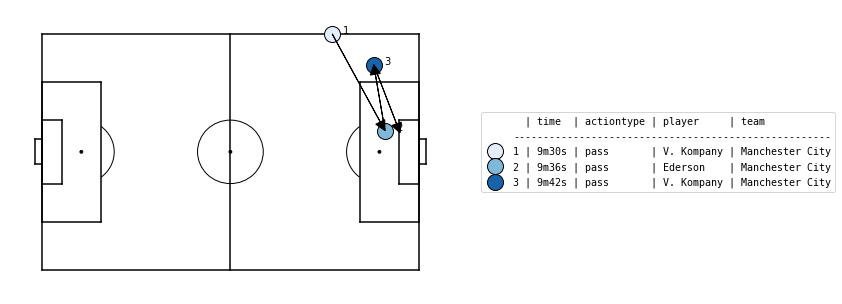

In [ ]:
for i in range(3):
    df_actions_to_plot = df_actions[145-i:146]
    plot_actions(df_actions_to_plot)

In [ ]:
delays = 3
features_to_delay = ['game_id', 'period_id', 'time_seconds', 'team_id',
                     'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'bodypart_id',
                     'type_id', 'result_id', 'type_name', 'result_name', 'bodypart_name',
                     'time_played']

In [ ]:
def create_delayed_features(df_actions, features_to_delay, delays):
    df_delays = [df_actions[features_to_delay].shift(step).add_suffix(f'-{step}') for step in range(0, delays)]
    return pd.concat(df_delays, axis=1)

In [ ]:
df_features = create_delayed_features(df_actions, features_to_delay, delays)

In [ ]:
location_cols = [f'{side}_{xy}-{delay}' for delay in reversed(range(0, delays))
                 for xy in ['x', 'y'] for side in ['start', 'end']]
df_features[action_id:action_id+1][location_cols]

,start_x-2,end_x-2,start_y-2,end_y-2,start_x-1,end_x-1,start_y-1,end_y-1,start_x-0,end_x-0,start_y-0,end_y-0
145,80.85,95.55,68.0,40.12,95.55,92.4,40.12,59.16,92.4,99.75,59.16,39.44


In [ ]:
cols = [f'{col}-{delay}' for delay in reversed(range(0, delays))
        for col in ['period_id', 'time_seconds', 'type_name', 'bodypart_name', 'result_name']]
df_features[action_id:action_id+1][cols]

,period_id-2,time_seconds-2,type_name-2,bodypart_name-2,result_name-2,period_id-1,time_seconds-1,type_name-1,bodypart_name-1,result_name-1,period_id-0,time_seconds-0,type_name-0,bodypart_name-0,result_name-0
145,1.0,570.284928,pass,foot,success,1.0,576.278186,pass,foot,success,1.0,582.313165,pass,foot,success


In [ ]:
def add_same_team(df_features, delays):
    for step in range(1, delays):
        df_features[f'team-{step}'] = df_features['team_id-0'] == df_features[f'team_id-{step}']

In [ ]:
add_same_team(df_features, delays)

In [ ]:
def invert_coordinates(df_features, delays):
    for step in range(1, delays):
        for side in ['start', 'end']:
            df_features.loc[~(df_features[f'team-{step}']), f'{side}_x-{step}'] = PITCH_LENGTH - df_features[f'{side}_x-{step}']
            df_features.loc[~(df_features[f'team-{step}']), f'{side}_y-{step}'] = PITCH_WIDTH - df_features[f'{side}_y-{step}']

In [ ]:
df_features[location_cols+['team-1', 'team-2']].tail(10)

,start_x-2,end_x-2,start_y-2,end_y-2,start_x-1,end_x-1,start_y-1,end_y-1,start_x-0,end_x-0,start_y-0,end_y-0,team-1,team-2
1269,0.00,2.10,0.00,0.68,2.10,7.35,0.68,4.08,7.35,6.30,4.08,4.08,True,True
1270,2.10,7.35,0.68,4.08,7.35,6.30,4.08,4.08,6.30,0.00,4.08,4.08,True,True
1271,7.35,6.30,4.08,4.08,6.30,0.00,4.08,4.08,5.00,68.25,34.00,27.88,False,False
1272,6.30,0.00,4.08,4.08,5.00,68.25,34.00,27.88,56.70,52.50,29.92,33.32,False,True
1273,5.00,68.25,34.00,27.88,56.70,52.50,29.92,33.32,52.50,31.50,33.32,31.28,True,False
1274,56.70,52.50,29.92,33.32,52.50,31.50,33.32,31.28,31.50,7.35,31.28,46.92,True,True
1275,52.50,31.50,33.32,31.28,31.50,7.35,31.28,46.92,7.35,7.35,46.92,46.92,True,True
1276,31.50,7.35,31.28,46.92,7.35,7.35,46.92,46.92,11.55,0.00,40.12,46.24,False,False
1277,7.35,7.35,46.92,46.92,11.55,0.00,40.12,46.24,0.00,4.20,68.00,63.24,False,True
1278,11.55,0.00,40.12,46.24,0.00,4.20,68.00,63.24,4.20,0.00,63.24,68.00,True,False


In [ ]:
invert_coordinates(df_features, delays)

In [ ]:
df_features[location_cols+['team-1', 'team-2']].tail(10)

,start_x-2,end_x-2,start_y-2,end_y-2,start_x-1,end_x-1,start_y-1,end_y-1,start_x-0,end_x-0,start_y-0,end_y-0,team-1,team-2
1269,0.00,2.10,0.00,0.68,2.10,7.35,0.68,4.08,7.35,6.30,4.08,4.08,True,True
1270,2.10,7.35,0.68,4.08,7.35,6.30,4.08,4.08,6.30,0.00,4.08,4.08,True,True
1271,97.65,98.70,63.92,63.92,98.70,105.00,63.92,63.92,5.00,68.25,34.00,27.88,False,False
1272,6.30,0.00,4.08,4.08,100.00,36.75,34.00,40.12,56.70,52.50,29.92,33.32,False,True
1273,100.00,36.75,34.00,40.12,56.70,52.50,29.92,33.32,52.50,31.50,33.32,31.28,True,False
1274,56.70,52.50,29.92,33.32,52.50,31.50,33.32,31.28,31.50,7.35,31.28,46.92,True,True
1275,52.50,31.50,33.32,31.28,31.50,7.35,31.28,46.92,7.35,7.35,46.92,46.92,True,True
1276,73.50,97.65,36.72,21.08,97.65,97.65,21.08,21.08,11.55,0.00,40.12,46.24,False,False
1277,7.35,7.35,46.92,46.92,93.45,105.00,27.88,21.76,0.00,4.20,68.00,63.24,False,True
1278,93.45,105.00,27.88,21.76,0.00,4.20,68.00,63.24,4.20,0.00,63.24,68.00,True,False


In [ ]:
def add_location_features(df_features, delays):
    for step in range(0, delays):
        for side in ['start', 'end']:
            # Normalize the X location
            key_x = f'{side}_x'
            df_features[f'{key_x}_norm-{step}'] = df_features[f'{key_x}-{step}'] / PITCH_LENGTH

            # Normalize the Y location
            key_y = f'{side}_y'
            df_features[f'{key_y}_norm-{step}'] = df_features[f'{key_y}-{step}'] / PITCH_WIDTH

            diff_x = GOAL_X - df_features[f'{side}_x-{step}']
            diff_y = abs(GOAL_Y - df_features[f'{side}_y-{step}'])
            df_features[f'{side}_distance_to_goal-{step}'] = np.sqrt(diff_x ** 2 + diff_y ** 2)
            df_features[f'{side}_angle_to_goal-{step}'] = np.divide(diff_x, diff_y, out=np.zeros_like(diff_x), where=(diff_y != 0))

            df_features[f'diff_x-{step}'] = df_features[f'end_x-{step}'] - df_features[f'start_x-{step}']
            df_features[f'diff_y-{step}'] = df_features[f'end_y-{step}'] - df_features[f'start_y-{step}']
            df_features[f'distance_covered-{step}'] = np.sqrt((df_features[f'end_x-{step}'] - df_features[f'start_x-{step}']) ** 2 +
                                             (df_features[f'end_y-{step}'] - df_features[f'start_y-{step}']) ** 2)

In [ ]:
add_location_features(df_features, delays)

In [ ]:
df_features.head()

,game_id-0,period_id-0,time_seconds-0,team_id-0,player_id-0,start_x-0,start_y-0,end_x-0,end_y-0,bodypart_id-0,type_id-0,result_id-0,type_name-0,result_name-0,bodypart_name-0,time_played-0,game_id-1,period_id-1,time_seconds-1,team_id-1,player_id-1,start_x-1,start_y-1,end_x-1,end_y-1,bodypart_id-1,type_id-1,result_id-1,type_name-1,result_name-1,bodypart_name-1,time_played-1,game_id-2,period_id-2,time_seconds-2,team_id-2,player_id-2,start_x-2,start_y-2,end_x-2,...,result_id-2,type_name-2,result_name-2,bodypart_name-2,time_played-2,team-1,team-2,start_x_norm-0,start_y_norm-0,start_distance_to_goal-0,start_angle_to_goal-0,diff_x-0,diff_y-0,distance_covered-0,end_x_norm-0,end_y_norm-0,end_distance_to_goal-0,end_angle_to_goal-0,start_x_norm-1,start_y_norm-1,start_distance_to_goal-1,start_angle_to_goal-1,diff_x-1,diff_y-1,distance_covered-1,end_x_norm-1,end_y_norm-1,end_distance_to_goal-1,end_angle_to_goal-1,start_x_norm-2,start_y_norm-2,start_distance_to_goal-2,start_angle_to_goal-2,diff_x-2,diff_y-2,distance_covered-2,end_x_norm-2,end_y_norm-2,end_distance_to_goal-2,end_angle_to_goal-2
0,2499873.0,1.0,4.077411,1611.0,7934.0,52.50,34.00,24.15,43.52,0,0,1,pass,success,foot,4.077411,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,False,0.50,0.50,52.500000,0.000000,-28.35,9.52,29.905734,0.23,0.64,81.408555,8.492647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2499873.0,1.0,7.135643,1611.0,101652.0,24.15,43.52,79.80,6.12,0,0,1,pass,success,foot,7.135643,2499873.0,1.0,4.077411,1611.0,7934.0,52.50,34.00,24.15,43.52,0.0,0.0,1.0,pass,success,foot,4.077411,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,True,False,0.23,0.64,81.408555,8.492647,55.65,-37.40,67.049851,0.76,0.09,37.581038,0.903874,0.50,0.50,52.500000,0.000000,-28.35,9.52,29.905734,0.23,0.64,81.408555,8.492647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2499873.0,1.0,12.618250,1625.0,105339.0,90.30,3.40,68.25,14.28,0,0,0,pass,fail,foot,12.618250,2499873.0,1.0,7.135643,1611.0,101652.0,80.85,24.48,25.20,61.88,0.0,0.0,1.0,pass,success,foot,7.135643,2499873.0,1.0,4.077411,1611.0,7934.0,52.50,34.00,80.85,...,1.0,pass,success,foot,4.077411,False,False,0.86,0.05,33.947754,0.480392,-22.05,10.88,24.588146,0.65,0.21,41.706605,1.863590,0.77,0.36,25.958677,2.536765,-55.65,37.40,67.049851,0.24,0.91,84.530080,2.862267,0.50,0.50,52.500000,0.000000,28.35,-9.52,29.905734,0.77,0.36,25.958677,2.536765
3,2499873.0,1.0,14.525614,1611.0,3413.0,68.25,14.28,70.35,26.52,0,0,0,pass,fail,foot,14.525614,2499873.0,1.0,12.618250,1625.0,105339.0,14.70,64.60,36.75,53.72,0.0,0.0,0.0,pass,fail,foot,12.618250,2499873.0,1.0,7.135643,1611.0,101652.0,24.15,43.52,79.80,...,1.0,pass,success,foot,7.135643,False,True,0.65,0.21,41.706605,1.863590,2.10,12.24,12.418841,0.67,0.39,35.448172,4.632353,0.14,0.95,95.343851,2.950980,22.05,-10.88,24.588146,0.35,0.79,71.041825,3.460953,0.23,0.64,81.408555,8.492647,55.65,-37.40,67.049851,0.76,0.09,37.581038,0.903874
4,2499873.0,1.0,17.735636,1625.0,38021.0,70.35,26.52,65.10,64.60,0,0,1,pass,success,foot,17.735636,2499873.0,1.0,14.525614,1611.0,3413.0,36.75,53.72,34.65,41.48,0.0,0.0,0.0,pass,fail,foot,14.525614,2499873.0,1.0,12.618250,1625.0,105339.0,90.30,3.40,68.25,...,0.0,pass,fail,foot,12.618250,False,True,0.67,0.39,35.448172,4.632353,-5.25,38.08,38.440199,0.62,0.95,50.282900,1.303922,0.35,0.79,71.041825,3.460953,-2.10,-12.24,12.418841,0.33,0.61,70.746540,9.405080,0.86,0.05,33.947754,0.480392,-22.05,10.88,24.588146,0.65,0.21,41.706605,1.863590


### Adding contextual features

In [ ]:
def add_sequence_pre_features(df_features, delays):
    delay = delays - 1
    df_features['xdiff_sequence_pre'] = df_features['start_x-0'] - df_features[f'start_x-{delay}']
    df_features['ydiff_sequence_pre'] = df_features['start_y-0'] - df_features[f'start_y-{delay}']
    df_features['time_sequence_pre'] = df_features['time_played-0'] - df_features[f'time_played-{delay}']

In [ ]:
add_sequence_pre_features(df_features, delays)

In [ ]:
def add_sequence_post_features(df_features, delays):
    delay = delays - 1
    df_features['xdiff_sequence_post'] = df_features['end_x-0'] - df_features[f'start_x-{delay}']
    df_features['ydiff_sequence_post'] = df_features['end_y-0'] - df_features[f'start_y-{delay}']

In [ ]:
add_sequence_post_features(df_features, delays)

In [ ]:
df_features[action_id:action_id+1]

,game_id-0,period_id-0,time_seconds-0,team_id-0,player_id-0,start_x-0,start_y-0,end_x-0,end_y-0,bodypart_id-0,type_id-0,result_id-0,type_name-0,result_name-0,bodypart_name-0,time_played-0,game_id-1,period_id-1,time_seconds-1,team_id-1,player_id-1,start_x-1,start_y-1,end_x-1,end_y-1,bodypart_id-1,type_id-1,result_id-1,type_name-1,result_name-1,bodypart_name-1,time_played-1,game_id-2,period_id-2,time_seconds-2,team_id-2,player_id-2,start_x-2,start_y-2,end_x-2,...,team-1,team-2,start_x_norm-0,start_y_norm-0,start_distance_to_goal-0,start_angle_to_goal-0,diff_x-0,diff_y-0,distance_covered-0,end_x_norm-0,end_y_norm-0,end_distance_to_goal-0,end_angle_to_goal-0,start_x_norm-1,start_y_norm-1,start_distance_to_goal-1,start_angle_to_goal-1,diff_x-1,diff_y-1,distance_covered-1,end_x_norm-1,end_y_norm-1,end_distance_to_goal-1,end_angle_to_goal-1,start_x_norm-2,start_y_norm-2,start_distance_to_goal-2,start_angle_to_goal-2,diff_x-2,diff_y-2,distance_covered-2,end_x_norm-2,end_y_norm-2,end_distance_to_goal-2,end_angle_to_goal-2,xdiff_sequence_pre,ydiff_sequence_pre,time_sequence_pre,xdiff_sequence_post,ydiff_sequence_post
145,2499873.0,1.0,582.313165,1625.0,8307.0,92.4,59.16,99.75,39.44,0,0,1,pass,success,foot,582.313165,2499873.0,1.0,576.278186,1625.0,71654.0,95.55,40.12,92.4,59.16,0.0,0.0,1.0,pass,success,foot,576.278186,2499873.0,1.0,570.284928,1625.0,8307.0,80.85,68.0,95.55,...,True,True,0.88,0.87,28.138685,0.500795,7.35,-19.72,21.045211,0.95,0.58,7.560165,0.965074,0.91,0.59,11.258637,1.544118,-3.15,19.04,19.298811,0.88,0.87,28.138685,0.500795,0.77,1.0,41.703987,0.710294,14.7,-27.88,31.518001,0.91,0.59,11.258637,1.544118,11.55,-8.84,12.028237,18.9,-28.56


## Generate features for a match

In [ ]:
def create_features_match(df_actions, features_to_delay, delays):
    df_action_features = add_action_type_dummies(df_actions)
    add_time_played(df_action_features)
    df_gamestate_features = create_delayed_features(df_action_features, features_to_delay, delays)
    add_same_team(df_gamestate_features, delays)
    invert_coordinates(df_gamestate_features, delays)
    add_location_features(df_gamestate_features, delays)
    add_sequence_pre_features(df_gamestate_features, delays)
    add_sequence_post_features(df_gamestate_features, delays)
    return df_gamestate_features

## Generate labels for a match

In [ ]:
def label_scores(df_actions, nr_actions):
    """
    This functiondf_actions determines whether a goal was scored by the team possessing 
    the ball within the next x actions
    """
    # merging goals, owngoals and team_ids

    goals = df_actions['type_name'].str.contains('shot') & (
        df_actions['result_id'] == 1
    )
    owngoals = df_actions['type_name'].str.contains('shot') & (
        df_actions['result_id'] == 2
    )
    y = pd.concat([goals, owngoals, df_actions['team_id']], axis=1)
    y.columns = ['goal', 'owngoal', 'team_id']

    # adding future results
    for i in range(1, nr_actions):
        for col in ['team_id', 'goal', 'owngoal']:
            shifted = y[col].shift(-i)
            shifted[-i:] = y[col][len(y) - 1]
            y[f'{col}+{i}'] = shifted

    scores = y['goal']
    for i in range(1, nr_actions):
        goal_scored = y[f'goal+{i}'] & (y[f'team_id+{i}'] == y['team_id'])
        own_goal_opponent = y[f'owngoal+{i}'] & (y[f'team_id+{i}'] != y['team_id'])
        scores = scores | goal_scored | own_goal_opponent

    return pd.DataFrame(scores, columns=['scores'])

In [ ]:
def label_concedes(df_actions, nr_actions):
    """
    This function determines whether a goal was scored by the team not 
    possessing the ball within the next x actions
    """
    # merging goals,owngoals and team_ids
    goals = df_actions['type_name'].str.contains('shot') & (
        df_actions['result_id'] == 1
    )
    owngoals = df_actions['type_name'].str.contains('shot') & (
        df_actions['result_id'] == 2
    )
    y = pd.concat([goals, owngoals, df_actions['team_id']], axis=1)
    y.columns = ['goal', 'owngoal', 'team_id']
    
    # adding future results
    for i in range(1, nr_actions):
        for col in ['team_id', 'goal', 'owngoal']:
            shifted = y[col].shift(-i)
            shifted[-i:] = y[col][len(y) - 1]
            y[f'{col}+{i}'] = shifted

    concedes = y['owngoal']
    for i in range(1, nr_actions):
        goal_opponent = y[f'goal+{i}'] & (y[f'team_id+{i}'] != y['team_id'])
        own_goal_team = y[f'owngoal+{i}'] & (y[f'team_id+{i}'] == y['team_id'])
        concedes = concedes | goal_opponent | own_goal_team

    return pd.DataFrame(concedes, columns=['concedes'])

In [ ]:
df_labels = pd.concat([label_scores(df_actions, nr_actions=10), 
                           label_concedes(df_actions, nr_actions=10)], 
                          axis=1)

In [ ]:
df_labels.tail(10)

,scores,concedes
1269,False,False
1270,False,False
1271,False,False
1272,False,False
1273,False,False
1274,False,False
1275,False,False
1276,False,False
1277,False,False
1278,False,False


In [ ]:
pd.merge(df_actions[['team_name', 'short_name', 'type_name']], 
         df_labels, 
         left_index=True, 
         right_index=True).tail(10)

,team_name,short_name,type_name,scores,concedes
1269,Manchester City FC,David Silva,take_on,False,False
1270,Manchester City FC,David Silva,pass,False,False
1271,Manchester United FC,David de Gea,goalkick,False,False
1272,Manchester City FC,Bernardo Silva,pass,False,False
1273,Manchester City FC,R. Sterling,dribble,False,False
1274,Manchester City FC,R. Sterling,pass,False,False
1275,Manchester City FC,K. De Bruyne,cross,False,False
1276,Manchester United FC,A. Young,interception,False,False
1277,Manchester City FC,K. De Bruyne,corner_short,False,False
1278,Manchester City FC,Bernardo Silva,pass,False,False


## Generate features and labels for all matches

In [ ]:
df_games = pd.read_hdf('spadl.h5', key='games')

In [ ]:
df_games.head()

,game_id,competition_id,season_id,game_date,home_team_id,away_team_id
0,2500089,364,181150,2018-05-13 14:00:00,1646,1659
1,2500090,364,181150,2018-05-13 14:00:00,1628,1627
2,2500091,364,181150,2018-05-13 14:00:00,1673,1609
3,2500092,364,181150,2018-05-13 14:00:00,1612,1651
4,2500093,364,181150,2018-05-13 14:00:00,1611,1644


In [ ]:
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    with pd.HDFStore('spadl.h5') as spadlstore:
        df_actions = spadlstore[f'actions/game_{game_id}']
        df_actions = (
            df_actions.merge(spadlstore['actiontypes'], how='left')
            .merge(spadlstore['results'], how='left')
            .merge(spadlstore['bodyparts'], how='left')
            .reset_index(drop=True)
        )
    
    df_features = create_features_match(df_actions, features_to_delay, delays)
    df_features.to_hdf('features.h5', f'game_{game_id}')
    
    df_labels = pd.concat([label_scores(df_actions, nr_actions=10), 
                           label_concedes(df_actions, nr_actions=10)], 
                          axis=1)
    df_labels.to_hdf('labels.h5', f'game_{game_id}')

100%|██████████| 1066/1066 [27:22<00:00,  1.54s/it]


## Load features

In [ ]:
dfs_features = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_features = pd.read_hdf('features.h5', key=f'game_{game_id}')
    df_features['game_id'] = game_id
    dfs_features.append(df_features)
df_features = pd.concat(dfs_features).reset_index(drop=True)

100%|██████████| 1066/1066 [09:38<00:00,  1.84it/s]


In [ ]:
df_features.tail(10)

,game_id-0,period_id-0,time_seconds-0,team_id-0,player_id-0,start_x-0,start_y-0,end_x-0,end_y-0,bodypart_id-0,type_id-0,result_id-0,type_name-0,result_name-0,bodypart_name-0,time_played-0,game_id-1,period_id-1,time_seconds-1,team_id-1,player_id-1,start_x-1,start_y-1,end_x-1,end_y-1,bodypart_id-1,type_id-1,result_id-1,type_name-1,result_name-1,bodypart_name-1,time_played-1,game_id-2,period_id-2,time_seconds-2,team_id-2,player_id-2,start_x-2,start_y-2,end_x-2,...,team-2,start_x_norm-0,start_y_norm-0,start_distance_to_goal-0,start_angle_to_goal-0,diff_x-0,diff_y-0,distance_covered-0,end_x_norm-0,end_y_norm-0,end_distance_to_goal-0,end_angle_to_goal-0,start_x_norm-1,start_y_norm-1,start_distance_to_goal-1,start_angle_to_goal-1,diff_x-1,diff_y-1,distance_covered-1,end_x_norm-1,end_y_norm-1,end_distance_to_goal-1,end_angle_to_goal-1,start_x_norm-2,start_y_norm-2,start_distance_to_goal-2,start_angle_to_goal-2,diff_x-2,diff_y-2,distance_covered-2,end_x_norm-2,end_y_norm-2,end_distance_to_goal-2,end_angle_to_goal-2,xdiff_sequence_pre,ydiff_sequence_pre,time_sequence_pre,xdiff_sequence_post,ydiff_sequence_post,game_id
1348523,2565557.0,2.0,2810.625133,712.0,5481.0,73.50,22.44,92.40,8.84,0,0,1,pass,success,foot,5510.625133,2565557.0,2.0,2810.625133,712.0,5481.0,75.60,25.84,73.50,22.44,0.0,9.0,1.0,tackle,success,foot,5510.625133,2565557.0,2.0,2809.163008,696.0,208694.0,27.30,44.88,31.50,...,False,0.70,0.33,33.554189,2.724913,18.90,-13.60,23.284544,0.88,0.13,28.138685,0.500795,0.72,0.38,30.511401,3.602941,-2.10,-3.40,3.996248,0.70,0.33,33.554189,2.724913,0.26,0.66,78.458042,7.141544,4.20,0.68,4.254692,0.30,0.67,74.403519,6.358131,46.20,-22.44,1.462125,65.10,-36.04,2565557
1348524,2565557.0,2.0,2814.448758,696.0,3650.0,92.40,8.84,85.05,8.16,0,9,1,tackle,success,foot,5514.448758,2565557.0,2.0,2810.625133,712.0,5481.0,31.50,45.56,12.60,59.16,0.0,0.0,1.0,pass,success,foot,5510.625133,2565557.0,2.0,2810.625133,712.0,5481.0,29.40,42.16,31.50,...,False,0.88,0.13,28.138685,0.500795,-7.35,-0.68,7.381389,0.81,0.12,32.645185,0.772059,0.30,0.67,74.403519,6.358131,-18.90,13.60,23.284544,0.12,0.87,95.764219,3.672496,0.28,0.62,76.039106,9.264706,2.10,3.40,3.996248,0.30,0.67,74.403519,6.358131,63.00,-33.32,3.823625,55.65,-34.00,2565557
1348525,2565557.0,2.0,2815.702805,696.0,3650.0,85.05,8.16,68.25,13.60,0,0,1,pass,success,foot,5515.702805,2565557.0,2.0,2814.448758,696.0,3650.0,92.40,8.84,85.05,8.16,0.0,9.0,1.0,tackle,success,foot,5514.448758,2565557.0,2.0,2810.625133,712.0,5481.0,31.50,45.56,12.60,...,False,0.81,0.12,32.645185,0.772059,-16.80,5.44,17.658811,0.65,0.20,42.032398,1.801471,0.88,0.13,28.138685,0.500795,-7.35,-0.68,7.381389,0.81,0.12,32.645185,0.772059,0.30,0.67,74.403519,6.358131,-18.90,13.60,23.284544,0.12,0.87,95.764219,3.672496,53.55,-37.40,5.077672,36.75,-31.96,2565557
1348526,2565557.0,2.0,2818.535860,712.0,167118.0,74.55,14.28,74.55,14.28,0,8,1,foul,success,foot,5518.535860,2565557.0,2.0,2815.702805,696.0,3650.0,19.95,59.84,36.75,54.40,0.0,0.0,1.0,pass,success,foot,5515.702805,2565557.0,2.0,2814.448758,696.0,3650.0,12.60,59.16,19.95,...,False,0.71,0.21,36.277829,1.544118,0.00,0.00,0.000000,0.71,0.21,36.277829,1.544118,0.19,0.88,88.888740,3.291409,16.80,-5.44,17.658811,0.35,0.80,71.233577,3.345588,0.12,0.87,95.764219,3.672496,7.35,0.68,7.381389,0.19,0.88,88.888740,3.291409,61.95,-44.88,4.087102,61.95,-44.88,2565557
1348527,2565557.0,2.0,2833.975834,696.0,3299.0,79.80,10.20,8.40,60.52,0,4,1,freekick_short,success,foot,5533.975834,2565557.0,2.0,2818.535860,712.0,167118.0,30.45,53.72,30.45,53.72,0.0,8.0,1.0,foul,success,foot,5518.535860,2565557.0,2.0,2815.702805,696.0,3650.0,85.05,8.16,68.25,...,True,0.76,0.15,34.662372,1.058824,-71.40,50.32,87.350228,0.08,0.89,100.174200,3.642534,0.29,0.79,77.114077,3.780426,0.00,0.00,0.000000,0.29,0.79,77.114077,3.780426,0.81,0.12,32.645185,0.772059,-16.80,5.44,17.658811,0.65,0.20,42.032398,1.801471,-5.25,2.04,18.273029,-76.65,52.36,2565557
1348528,2565557.0,2.0,2836.932876,696.0,38436.0,8.40,60.52,26.25,

## Load labels

In [ ]:
dfs_labels = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']  
    df_labels = pd.read_hdf('labels.h5', key=f'game_{game_id}')
    df_labels['game_id'] = game_id
    dfs_labels.append(df_labels)
df_labels = pd.concat(dfs_labels).reset_index(drop=True)

100%|██████████| 1066/1066 [00:16<00:00, 63.94it/s]


In [ ]:
df_labels.tail(10)

,scores,concedes,game_id
1348523,False,False,2565557
1348524,False,False,2565557
1348525,False,False,2565557
1348526,False,False,2565557
1348527,False,False,2565557
1348528,False,False,2565557
1348529,False,False,2565557
1348530,False,False,2565557
1348531,False,False,2565557
1348532,False,False,2565557


# Train models

## Determine training and test set

In [ ]:
df_games_train = df_games[
    df_games['competition_id'] != 795
]

In [ ]:
df_games_train[375:385]

,game_id,competition_id,season_id,game_date,home_team_id,away_team_id
375,2499723,364,181150,2017-08-12 14:00:00,1623,1639
376,2499726,364,181150,2017-08-12 14:00:00,1619,10531
377,2499728,364,181150,2017-08-12 14:00:00,1627,1659
378,2499727,364,181150,2017-08-12 11:30:00,1644,1612
379,2499719,364,181150,2017-08-11 18:45:00,1609,1631
0,2517036,426,181137,2018-05-12 13:30:00,2444,2445
1,2517037,426,181137,2018-05-12 13:30:00,2482,2447
2,2517038,426,181137,2018-05-12 13:30:00,2457,2975
3,2517039,426,181137,2018-05-12 13:30:00,2453,2481
4,2517040,426,181137,2018-05-12 13:30:00,2449,2462


In [ ]:
df_games_test = df_games[
    df_games['competition_id'] == 795
]

In [ ]:
df_games_test.tail(10)

,game_id,competition_id,season_id,game_date,home_team_id,away_team_id
370,2565553,795,181144,2017-08-21 20:00:00,683,701
371,2565548,795,181144,2017-08-21 18:15:00,695,682
372,2565555,795,181144,2017-08-20 20:15:00,677,675
373,2565554,795,181144,2017-08-20 18:15:00,676,684
374,2565550,795,181144,2017-08-20 16:15:00,678,698
375,2565552,795,181144,2017-08-19 20:15:00,680,691
376,2565551,795,181144,2017-08-19 18:15:00,756,679
377,2565549,795,181144,2017-08-19 16:15:00,692,687
378,2565556,795,181144,2017-08-18 20:15:00,674,714
379,2565557,795,181144,2017-08-18 18:15:00,712,696


## Split the Dataset

In [ ]:
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(
    df_features,
    df_labels,
    test_size=0.10,
    random_state=42,
    stratify=df_labels['scores'].astype(str) + '_' + df_labels['concedes'].astype(str)
)

In [ ]:
df_y_train['scores'].mean()

0.015800718311843577

In [ ]:
df_y_test['scores'].mean()

0.015802275053020304

In [ ]:
df_y_train['concedes'].mean()

0.005034280069112179

In [ ]:
df_y_test['concedes'].mean()

0.005035074969967521

In [ ]:
df_X_train = df_features[df_features['game_id'].isin(df_games_train['game_id'].unique())]
df_X_test = df_features[df_features['game_id'].isin(df_games_test['game_id'].unique())]
df_y_train = df_labels[df_labels['game_id'].isin(df_games_train['game_id'].unique())]
df_y_test = df_labels[df_labels['game_id'].isin(df_games_test['game_id'].unique())]

In [ ]:
df_X_train.columns

Index(['game_id-0', 'period_id-0', 'time_seconds-0', 'team_id-0',
       'player_id-0', 'start_x-0', 'start_y-0', 'end_x-0', 'end_y-0',
       'bodypart_id-0', 'type_id-0', 'result_id-0', 'type_name-0',
       'result_name-0', 'bodypart_name-0', 'time_played-0', 'game_id-1',
       'period_id-1', 'time_seconds-1', 'team_id-1', 'player_id-1',
       'start_x-1', 'start_y-1', 'end_x-1', 'end_y-1', 'bodypart_id-1',
       'type_id-1', 'result_id-1', 'type_name-1', 'result_name-1',
       'bodypart_name-1', 'time_played-1', 'game_id-2', 'period_id-2',
       'time_seconds-2', 'team_id-2', 'player_id-2', 'start_x-2', 'start_y-2',
       'end_x-2', 'end_y-2', 'bodypart_id-2', 'type_id-2', 'result_id-2',
       'type_name-2', 'result_name-2', 'bodypart_name-2', 'time_played-2',
       'team-1', 'team-2', 'start_x_norm-0', 'start_y_norm-0',
       'start_distance_to_goal-0', 'start_angle_to_goal-0', 'diff_x-0',
       'diff_y-0', 'distance_covered-0', 'end_x_norm-0', 'end_y_norm-0',
       'en

## Construct baseline classifiers

### Provide list of Features

In [ ]:
features = [
    'start_distance_to_goal-0',
    'end_distance_to_goal-0',
    'start_distance_to_goal-1',
    'end_distance_to_goal-1',
    'start_distance_to_goal-2',
    'end_distance_to_goal-2',
    'start_angle_to_goal-0',
    'end_angle_to_goal-0',
    'start_angle_to_goal-1',
    'end_angle_to_goal-1',
    'start_angle_to_goal-2',
    'end_angle_to_goal-2',
    'team-1',
    'team-2',
    'result_id-0',
    'result_id-1',
    'result_id-2'
]

### Provide lists of class Labels

In [ ]:
labels = [
    'scores',
    'concedes'
]

## Train classifiers
The following cell trains an XGBoost classifier for each label using conservative hyperparamters for the learning algorithm, which will serve as baseline models.

In [ ]:
%%time
models = {}
for label in tqdm(labels):
    model = XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False,
        n_estimators=100,
        max_depth=3
    )
    model.fit(
        X= df_X_train[features],
        y= df_y_train[label]
    )
    models[label] = model

100%|██████████| 2/2 [03:02<00:00, 91.44s/it]

CPU times: user 3min 2s, sys: 507 ms, total: 3min 3s
Wall time: 3min 2s


In [ ]:
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, use_label_encoder=False, verbosity=1)

## Investigate feature importances

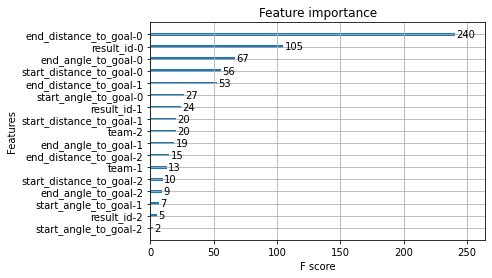

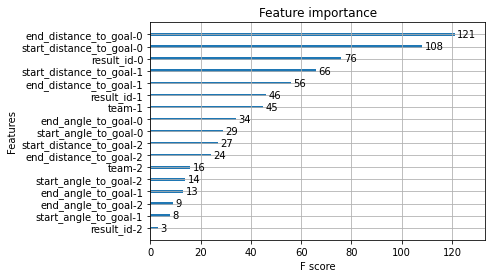

In [ ]:
for label in labels:
    plot_importance(models[label])

## Investigate SHAP values

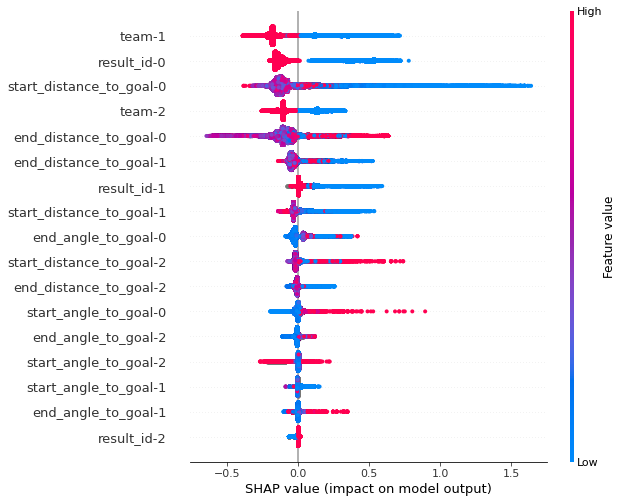

In [ ]:
label='scores'
label='concedes'

explainer = shap.TreeExplainer(models[label])

shap_values = explainer.shap_values(df_X_test[features])
shap.summary_plot(shap_values, df_X_test[features])

## Estimate probabilities

In [ ]:
dfs_predictions = {}
for label in tqdm(labels):
    model = models[label]
    probabilities = model.predict_proba(
        df_X_test[features]
    )
    predictions = probabilities[:, 1]
    dfs_predictions[label] = pd.Series(predictions, index=df_X_test.index)
df_predictions = pd.concat(dfs_predictions, axis=1).reset_index(drop=True)

100%|██████████| 2/2 [00:03<00:00,  1.90s/it]


In [ ]:
df_predictions.tail(10)

,scores,concedes
474865,0.016870,0.003888
474866,0.010990,0.019070
474867,0.009822,0.003955
474868,0.010228,0.006641
474869,0.022843,0.005778
474870,0.014280,0.004252
474871,0.038523,0.002637
474872,0.010703,0.005260
474873,0.019185,0.006301
474874,0.011564,0.020906


## Evaluate probabilities

### Compute base rate probabilities

In [ ]:
df_base_rates = pd.DataFrame(
    {
      label:np.full(len(df_y_test[label]), df_y_train[label].mean()) for label in labels
    }
)

In [ ]:
df_base_rates.head(10)

,scores,concedes
0,0.015817,0.004989
1,0.015817,0.004989
2,0.015817,0.004989
3,0.015817,0.004989
4,0.015817,0.004989
5,0.015817,0.004989
6,0.015817,0.004989
7,0.015817,0.004989
8,0.015817,0.004989
9,0.015817,0.004989


### Compute Brier score loss for goal scored model

In [ ]:
brier_score_loss(
    y_true=df_y_test['scores'],
    y_prob=df_base_rates['scores']
)

0.015521760520016196

In [ ]:
brier_score_loss(
    y_true=df_y_test['scores'],
    y_prob=df_predictions['scores']
)

0.013505164460236413

### Compute Brier score loss for goal conceded model

In [ ]:
brier_score_loss(
    y_true=df_y_test['concedes'],
    y_prob=df_base_rates['concedes']
)

0.005090967331752013

In [ ]:
brier_score_loss(
    y_true=df_y_test['concedes'],
    y_prob=df_predictions['concedes']
)

0.005060952667039074

### Plot calibration curve and probability histogram

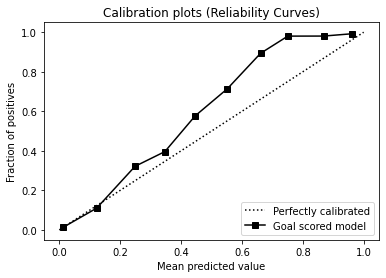

In [ ]:
plot_calibration_curve(
    y_true=df_y_test['scores'],
    probas_list=[df_predictions['scores'].tolist()],
    clf_names=['Goal scored model'],
    n_bins=10,
)
plt.show()

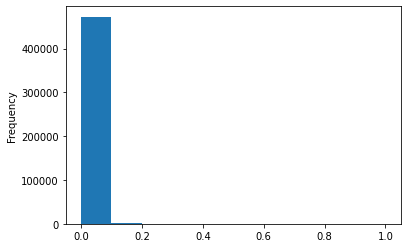

In [ ]:
df_predictions['scores'].plot.hist(
    range=(0, 1),
    bins=10,
)
plt.show()

## Optimize classifiers

In [ ]:
%%time
models_cv = {}
for label in tqdm(labels):
    model = GridSearchCV(
        estimator=XGBClassifier(
            eval_metric='logloss',
            use_label_encoder=False,
        ),
        param_grid={
            'n_estimators': [10, 50, 100],
            'max_depth': [3, 4, 6]
        },
        scoring='neg_brier_score',
        refit=True,  # train final model on full training set using best hyperparameters
        verbose=10,
        n_jobs=4
    )
    model.fit(
        X=df_X_train[features],
        y=df_y_train[label]
    )
    models_cv[label] = model

  0%|          | 0/2 [00:00<?, ?it/s]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  5.4min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 10.7min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 15.5min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 24.7min
[Parallel(n_jobs=4)]: Done  43 out of  45 | elapsed: 42.8min remaining:  2.0min
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed: 45.8min finished
 50%|█████     | 1/2 [49:03<49:03, 2943.13s/it]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  6.0min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 11.0min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 15.8min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 24.2min
[Parallel(n_jobs=4)]: Done  43 out of  45 | elapsed: 41.6min remaining:  1.9min
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed: 43.6min finished
100%|██████████| 2/2 [1:36:52<00:00, 2906.15s/it]

CPU times: user 7min 56s, sys: 6.47 s, total: 8min 2s
Wall time: 1h 36min 52s


In [ ]:
dump(models_cv, "models_cv")
print("Saved model to: model_cv")

Saved model to: model_cv


## Estimate probability

In [ ]:
dfs_predictions_cv = {}
for label in tqdm(labels):
    model = models_cv[label]
    probabilities = model.predict_proba(
        df_X_test[features]
    )
    predictions = probabilities[:, 1]
    dfs_predictions_cv[label] = pd.Series(predictions, index=df_X_test.index)
df_predictions_cv = pd.concat(dfs_predictions, axis=1)

100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


In [ ]:
df_predictions_cv

,scores,concedes
873658,0.003525,0.002461
873659,0.009952,0.002422
873660,0.015867,0.002335
873661,0.008446,0.006544
873662,0.005049,0.005645
...,...,...
1348528,0.014280,0.004252
1348529,0.038523,0.002637
1348530,0.010703,0.005260
1348531,0.019185,0.006301


## Evaluate probability

### Compute Brier score loss for goal scored model

In [ ]:
brier_score_loss(
    y_true=df_y_test['scores'],
    y_prob=df_base_rates['scores']
)

0.015521760520016196

In [ ]:
brier_score_loss(
    y_true=df_y_test['scores'],
    y_prob=df_predictions_cv['scores']
)

0.013505164460236413

### Compute Brier score loss for goal conceded model

In [ ]:
brier_score_loss(
    y_true=df_y_test['concedes'],
    y_prob=df_base_rates['concedes']
)

0.005090967331752013

In [ ]:
brier_score_loss(
    y_true=df_y_test['concedes'],
    y_prob=df_predictions_cv['concedes']
)

0.005060952667039074

### Plot calibration curve and probability histogram

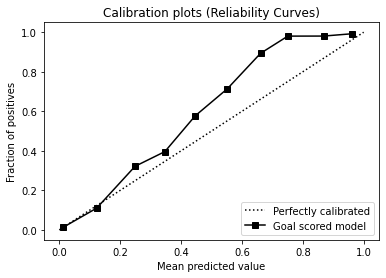

In [ ]:
plot_calibration_curve(
    y_true=df_y_test['scores'],
    probas_list=[df_predictions_cv['scores'].tolist()],
    clf_names=['Goal scored model'],
    n_bins=10,
)
plt.show()

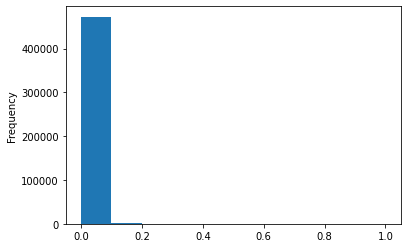

In [ ]:
df_predictions_cv['scores'].plot.hist(
    range=(0, ),
    bins=10,
)
plt.show()

## Construct final classifiers

In [ ]:
model_scores_final = XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=4
)

In [ ]:
model_scores_final.fit(
    X=df_X_train[features],
    y=df_y_train[label]
)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, use_label_encoder=False, verbosity=1)

In [ ]:
dfs_predictions_final = {}
for label in tqdm(labels):
    model = model_scores_final
    probabilities = model.predict_proba(
        df_X_test[features]
    )
    predictions = probabilities[:, 1]
    dfs_predictions_final = pd.Series(predictions, index=df_X_test.index)
dfs_predictions_final = pd.concat(dfs_predictions, axis=1)

100%|██████████| 2/2 [00:04<00:00,  2.31s/it]


In [ ]:
dfs_predictions_final

,scores,concedes
873658,0.003525,0.002461
873659,0.009952,0.002422
873660,0.015867,0.002335
873661,0.008446,0.006544
873662,0.005049,0.005645
...,...,...
1348528,0.014280,0.004252
1348529,0.038523,0.002637
1348530,0.010703,0.005260
1348531,0.019185,0.006301


# Analyze models and results

## Load actions, players and teams and value actions

In [ ]:
df_players = pd.read_hdf('spadl.h5', key='players')
df_teams = pd.read_hdf('spadl.h5', key='teams')

In [ ]:
dfs_actions = []
for _, game in tqdm(df_games_test.iterrows(), total=len(df_games_test)):
    game_id = game['game_id']
    with pd.HDFStore('spadl.h5') as spadlstore:
        df_actions = spadlstore[f'actions/game_{game_id}']
        df_actions = (
            df_actions.merge(spadlstore['actiontypes'], how='left')
            .merge(spadlstore['results'], how='left')
            .merge(spadlstore['bodyparts'], how='left')
            .merge(spadlstore['players'], how='left')
            .merge(spadlstore['teams'], how='left')
            .reset_index()
            .rename(columns={'index': 'action_id'})
        )
    
    dfs_actions.append(df_actions)
df_actions = pd.concat(dfs_actions).reset_index(drop=True)

100%|██████████| 380/380 [01:01<00:00,  6.14it/s]


In [ ]:
df_actions_predictions = pd.concat([df_actions, df_predictions], axis=1)

In [ ]:
dfs_values = []
for game_id, game_predictions in df_actions_predictions.groupby('game_id'):
    df_values = value(game_predictions, game_predictions['scores'], game_predictions['concedes'])
    
    df_all = pd.concat([game_predictions, df_values], axis=1)
    dfs_values.append(df_all)

In [ ]:
df_values = (pd.concat(dfs_values)
    .sort_values(['game_id', 'period_id', 'time_seconds'])
    .reset_index(drop=True)
)

In [ ]:
df_values.tail(10)

,action_id,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,bodypart_id,type_id,result_id,type_name,result_name,bodypart_name,short_name,first_name,last_name,birth_date,short_team_name,team_name,scores,concedes,offensive_value,defensive_value,vaep_value
474865,1482,2565927.0,2.0,2917.139970,675.0,3309.0,46.20,62.56,8.40,48.28,0,4,0,freekick_short,fail,foot,R. Varane,Raphaël,Varane,1993-04-25,Real Madrid,Real Madrid Club de Fútbol,0.008095,0.012736,0.008095,-0.012736,-0.004641
474866,1483,2565927.0,2.0,2925.547631,682.0,3486.0,8.40,48.28,14.70,55.08,2,0,1,pass,success,other,Andrés Fernández,Andrés Eduardo,Fernández Moreno,1986-12-17,Villarreal,Villarreal Club de Fútbol,0.016995,0.009079,0.004260,-0.000985,0.003275
474867,1484,2565927.0,2.0,2928.665268,682.0,3695.0,14.70,55.08,37.80,44.88,0,21,1,dribble,success,foot,Álvaro González,Álvaro,González Soberón,1990-01-08,Villarreal,Villarreal Club de Fútbol,0.011680,0.004030,-0.005316,0.005050,-0.000266
474868,1485,2565927.0,2.0,2931.782904,682.0,3695.0,37.80,44.88,47.25,32.64,0,0,1,pass,success,foot,Álvaro González,Álvaro,González Soberón,1990-01-08,Villarreal,Villarreal Club de Fútbol,0.015308,0.002403,0.003628,0.001627,0.005255
474869,1486,2565927.0,2.0,2932.188168,682.0,20623.0,47.25,32.64,69.30,51.00,0,21,1,dribble,success,foot,R. Soriano,Roberto,Soriano,1991-02-08,Villarreal,Villarreal Club de Fútbol,0.013979,0.002130,-0.001329,0.000273,-0.001056
474870,1487,2565927.0,2.0,2939.077491,682.0,20623.0,69.30,51.00,92.40,66.64,0,0,1,pass,success,foot,R. Soriano,Roberto,Soriano,1991-02-08,Villarreal,Villarreal Club de Fútbol,0.017741,0.002298,0.003762,-0.000168,0.003594
474871,1488,2565927.0,2.0,2940.515560,682.0,122832.0,92.40,66.64,101.85,53.72,0,21,1,dribble,success,foot,Salem Al Dawsari,Salem Mohammed,Al Dawsari,1991-08-19,Villarreal,Villarreal Club de Fútbol,0.037299,0.002287,0.019558,0.000010,0.019568
474872,1489,2565927.0,2.0,2942.098761,682.0,122832.0,101.85,53.72,96.60,50.32,0,1,0,cross,fail,foot,Salem Al Dawsari,Salem Mohammed,Al Dawsari,1991-08-19,Villarreal,Villarreal Club de Fútbol,0.022744,0.005142,-0.014555,-0.002854,-0.017409
474873,1490,2565927.0,2.0,2943.089232,675.0,40756.0,96.60,50.32,95.55,38.08,0,0,1,pass,success,foot,Casemiro,Carlos Henrique,Casimiro,1992-02-23,Real Madrid,Real Madrid Club de Fútbol,0.017053,0.039011,0.011912,-0.016267,-0.004355
474874,1491,2565927.0,2.0,2943.668846,675.0,3306.0,95.55,38.08,95.55,38.08,0,18,0,clearance,fail,foot,Sergio Ramos,Sergio,Ramos García,1986-03-30,Real Madrid,Real Madrid Club de Fútbol,0.022560,0.020325,0.005506,0.018685,0.024192


## Rate players

In [ ]:
df_ranking = (df_values[['player_id', 'team_name', 'short_name', 'vaep_value']]
    .groupby(['player_id', 'team_name', 'short_name'])
    .agg(vaep_count=('vaep_value', 'count'), 
         vaep_mean=('vaep_value', 'mean'),
         vaep_sum=('vaep_value', 'sum'))
    .sort_values('vaep_sum', ascending=False)
    .reset_index()
)

In [ ]:
df_ranking.head(10)

,player_id,team_name,short_name,vaep_count,vaep_mean,vaep_sum
0,3359.0,FC Barcelona,L. Messi,2753,0.011012,30.316528
1,3322.0,Real Madrid Club de Fútbol,Cristiano Ronaldo,1182,0.014627,17.289354
2,7972.0,FC Barcelona,L. Suárez,1549,0.011158,17.283705
3,3676.0,Real Sociedad de Fútbol,Illarramendi,3172,0.005297,16.803581
4,3840.0,Real Club Celta de Vigo,Iago Aspas,1771,0.009429,16.699558
5,3682.0,Club Atlético de Madrid,A. Griezmann,1394,0.011230,15.655220
6,395636.0,Real Club Celta de Vigo,Maxi Gómez,949,0.016275,15.445163
7,8278.0,Real Madrid Club de Fútbol,G. Bale,1104,0.012222,13.493335
8,70129.0,Valencia Club de Fútbol,Rodrigo,1334,0.009833,13.117146
9,3714.0,Girona FC,C. Stuani,731,0.017687,12.929440


In [ ]:
df_player_games = pd.read_hdf('spadl.h5', 'player_games')
df_player_games = df_player_games[df_player_games['game_id'].isin(df_games['game_id'])]

In [ ]:
df_minutes_played = (df_player_games[['player_id', 'minutes_played']]
    .groupby('player_id')
    .sum()
    .reset_index()
)

In [ ]:
df_minutes_played.head()

,player_id,minutes_played
0,33,92.903192
1,36,1238.400194
2,38,382.741398
3,48,3344.850202
4,54,3350.424005


In [ ]:
df_ranking_p90 = df_ranking.merge(df_minutes_played)
df_ranking_p90['vaep_rating'] = df_ranking_p90['vaep_sum'] * 90 / df_ranking_p90['minutes_played']
df_ranking_p90['actions_p90'] = df_ranking_p90['vaep_count'] * 90 / df_ranking_p90['minutes_played']

In [ ]:
MIN_THRESHOLD = 450

In [ ]:
df_ranking_p90 = df_ranking_p90[df_ranking_p90['minutes_played']>MIN_THRESHOLD]

In [ ]:
df_ranking_p90 = df_ranking_p90.sort_values('vaep_rating', ascending=False)
df_ranking_p90.head(10)

,player_id,team_name,short_name,vaep_count,vaep_mean,vaep_sum,minutes_played,vaep_rating,actions_p90
0,3359.0,FC Barcelona,L. Messi,2753,0.011012,30.316528,3107.979597,0.877898,79.720601
1,3322.0,Real Madrid Club de Fútbol,Cristiano Ronaldo,1182,0.014627,17.289354,2357.056994,0.660163,45.132553
7,8278.0,Real Madrid Club de Fútbol,G. Bale,1104,0.012222,13.493335,1852.140087,0.655674,53.646050
106,225946.0,Real Betis Balompié,A. Sanabria,239,0.025186,6.019353,901.735926,0.600777,23.853990
5,3682.0,Club Atlético de Madrid,A. Griezmann,1394,0.011230,15.655220,2620.010232,0.537773,47.885309
55,25472.0,Villarreal Club de Fútbol,C. Bakambu,495,0.015522,7.683442,1297.283765,0.533044,34.340983
276,266885.0,Girona FC,M. Olunga,157,0.017345,2.723125,462.684560,0.529694,30.539165
2,7972.0,FC Barcelona,L. Suárez,1549,0.011158,17.283705,2997.257240,0.518986,46.512524
103,364820.0,Real Betis Balompié,Loren Morón,359,0.017254,6.194344,1092.796604,0.510151,29.566344
4,3840.0,Real Club Celta de Vigo,Iago Aspas,1771,0.009429,16.699558,3039.079676,0.494545,52.446799


### Quantity - Quality trade-off

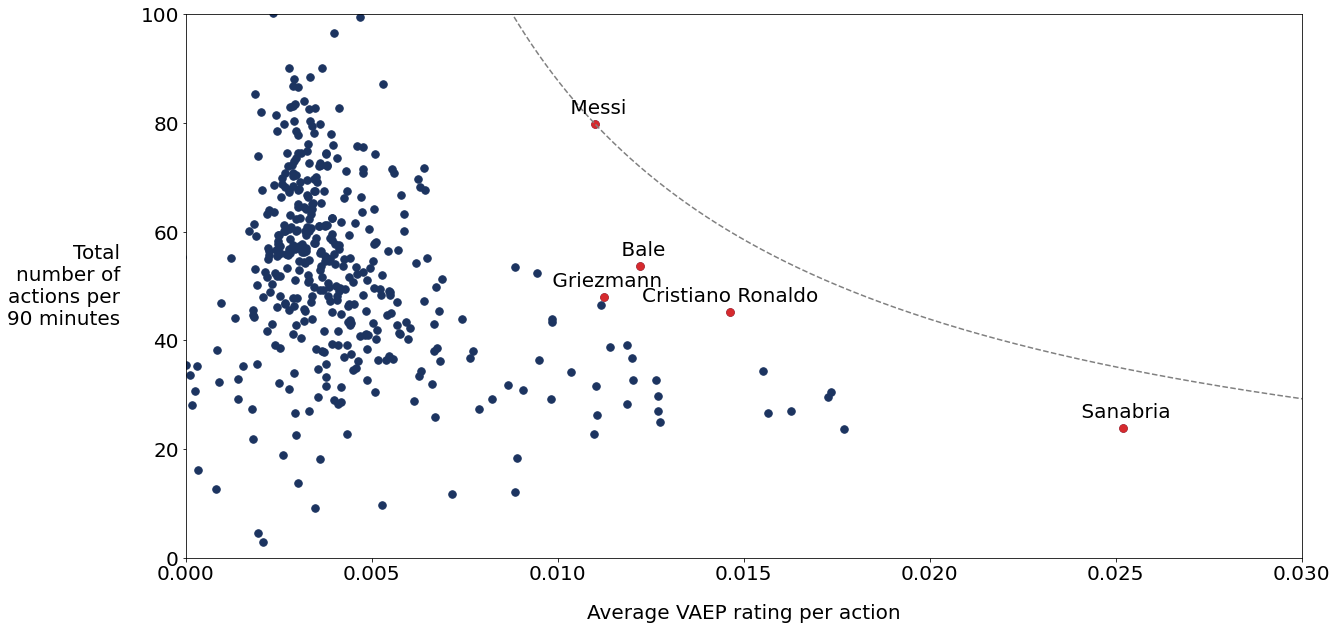

In [ ]:
plt.figure(figsize=(20, 10))
x = list(df_ranking_p90['vaep_mean'])
y = list(df_ranking_p90['actions_p90'])
plt.plot(x, y, '.', c='#1C3460', markersize=15)

# Plot 5 best players
x_best = list(df_ranking_p90['vaep_mean'][0:5])
y_best = list(df_ranking_p90['actions_p90'][0:5])
names = list(df_ranking_p90['short_name'][0:5])
names = [name.split(".")[-1] for name in names]
plt.plot(x_best, y_best, '.', c='#D62A2E', markersize=15)
for i, txt in enumerate(names):
    plt.annotate(txt, (x[i], y[i] + 2), fontsize=20, horizontalalignment='center')

best_player = x[0] * y[0]
yi = np.arange(0.1, 100, 0.1)
xi = [best_player / i for i in yi]
plt.plot(xi, yi, '--', c='grey')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0, 0.03)
plt.ylim(0, 100)
plt.xlabel('Average VAEP rating per action', labelpad=20, fontsize=20)
plt.ylabel('Total\nnumber of\nactions per\n90 minutes', rotation=0, labelpad=20,
            verticalalignment='center', horizontalalignment='right', fontsize=20)

plt.show()

### Risk - Reward Trade-off

In [ ]:
df_risk = pd.pivot_table(df_values, values='vaep_value', index=['player_id', 'short_name', 'team_name'],
                                              columns=['result_name'], aggfunc=np.sum,
                                              fill_value=0)[['success', 'fail']]
df_risk = df_risk.reset_index()
df_risk = df_risk[0:-1]
df_risk = pd.merge(df_risk, df_minutes_played, on=['player_id'])
for result in ['success', 'fail']:
    df_risk[result] = df_risk[result] / df_risk['minutes_played'] * 90

In [ ]:
df_risk = df_risk[df_risk['minutes_played']>MIN_THRESHOLD]
df_risk['vaep_rating'] = df_risk['success'] + df_risk['fail']
df_risk.sort_values('fail')

,player_id,short_name,team_name,success,fail,minutes_played,vaep_rating
41,3359.0,L. Messi,FC Barcelona,1.066060,-0.189883,3107.979597,0.876177
476,281255.0,E. Mor,Real Club Celta de Vigo,0.351725,-0.188034,716.504659,0.163691
134,3822.0,Rubén Blanco,Real Club Celta de Vigo,-0.338553,-0.183499,2052.730402,-0.522052
26,3322.0,Cristiano Ronaldo,Real Madrid Club de Fútbol,0.838949,-0.182457,2357.056994,0.656492
94,3605.0,Jorge Molina,Getafe Club de Fútbol,0.212484,-0.180727,2886.306136,0.031757
...,...,...,...,...,...,...,...
152,3970.0,Gálvez,SD Eibar,0.087023,-0.003238,2043.333815,0.083785
157,4009.0,M. Lacen,Getafe Club de Fútbol,0.007210,-0.001159,1163.938169,0.006052
425,247222.0,Medrán,Valencia Club de Fútbol,0.009670,-0.000703,1057.592519,0.008967
265,20393.0,D. Bonera,Villarreal Club de Fútbol,0.168319,0.001000,1296.145024,0.169319


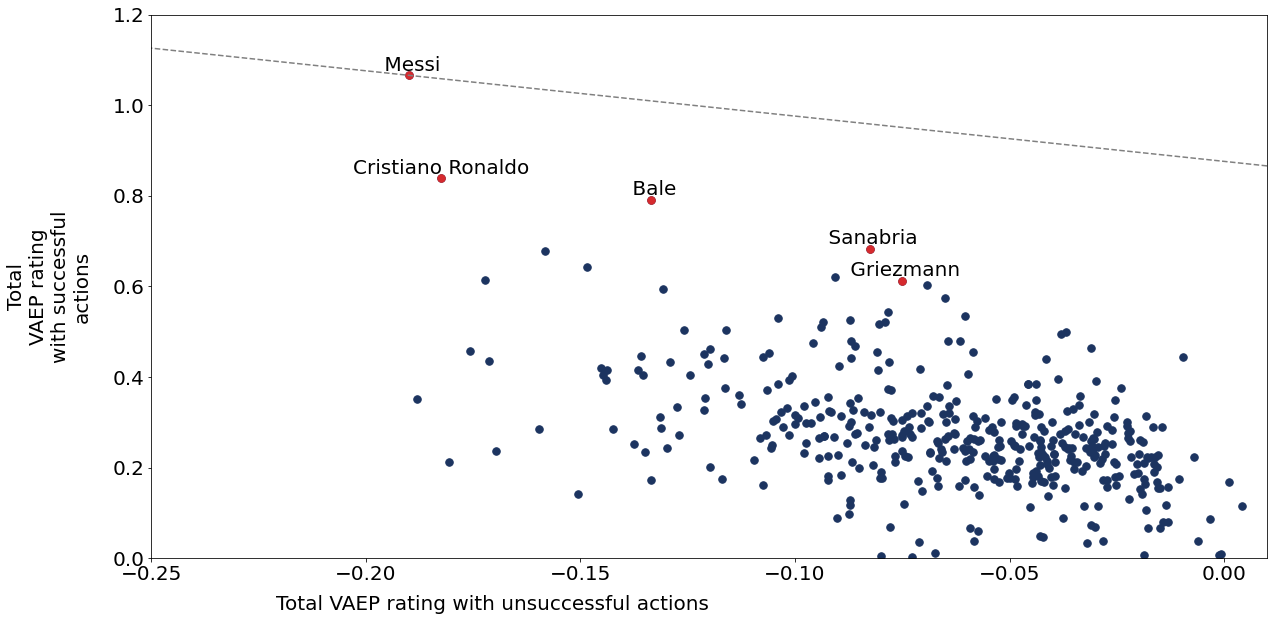

In [ ]:
df_risk = df_risk.sort_values('vaep_rating', ascending=False)

plt.figure(figsize=(20, 10))
x = list(df_risk['fail'])
y = list(df_risk['success'])
plt.plot(x, y, '.', c='#1C3460', markersize=15)

# Plot 5 best players
x_best = list(df_risk['fail'][0:5])
y_best = list(df_risk['success'][0:5])
names = list(df_risk['short_name'][0:5])
names = [name.split(".")[-1] for name in names]
plt.plot(x_best, y_best, '.', c='#D62A2E', markersize=15)
for i, txt in enumerate(names):
    plt.annotate(txt, (x[i], y[i] + 0.01), fontsize=20, horizontalalignment='center')

best_player = x[0] + y[0]
yi = np.arange(0.1, 2, 0.1)
xi = [best_player - i for i in yi]
plt.plot(xi, yi, '--', c='grey')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(-0.25, 0.01)
plt.ylim(0, 1.2)
plt.xlabel('Total VAEP rating with unsuccessful actions', rotation=0, labelpad=20,
            verticalalignment='center', horizontalalignment='right', fontsize=20)
plt.ylabel('Total\nVAEP rating\nwith successful\nactions', labelpad=20, fontsize=20)

plt.show()

### Rating per action type

In [ ]:
df_rating_action = pd.pivot_table(df_values, values='vaep_value', index=['player_id', 'short_name', 'team_name'],
                                              columns=['type_name'], aggfunc=np.sum,
                                              fill_value=0, margins=True, margins_name='total')
df_rating_action = df_rating_action.reset_index()
df_rating_action = df_rating_action[0:-1]
df_rating_action = pd.merge(df_rating_action, df_minutes_played, on=['player_id'])
for action in df_values['type_name'].unique():
    df_rating_action[action] = df_rating_action[action] / df_rating_action['minutes_played'] * 90

In [ ]:
df_rating_action[df_rating_action['minutes_played']>MIN_THRESHOLD].sort_values('shot', 
                                                                               ascending=False).head(10)

,player_id,short_name,team_name,clearance,corner_crossed,corner_short,cross,dribble,foul,freekick_crossed,freekick_short,goalkick,interception,keeper_save,pass,shot,shot_freekick,shot_penalty,tackle,take_on,throw_in,total,minutes_played
399,225946,A. Sanabria,Real Betis Balompié,-0.001227,0.000000,0.000000,-0.011346,0.013944,0.008634,0.000000,-0.000375,0.0,-0.000347,0.0,-0.049785,0.633920,0.000000,0.000000,-0.000705,0.008063,0.000000,6.019353,901.735926
26,3322,Cristiano Ronaldo,Real Madrid Club de Fútbol,0.003302,0.000000,-0.003305,0.006651,0.041097,0.008977,0.000436,0.000338,0.0,0.003119,0.0,0.038766,0.594737,0.003612,-0.041761,-0.000361,0.001610,0.002945,17.289354,2357.056994
41,3359,L. Messi,FC Barcelona,0.000000,-0.007052,-0.016333,-0.004296,0.052255,0.005802,0.010213,0.011887,0.0,0.000801,0.0,0.177002,0.557719,0.118453,-0.057050,0.000515,0.027244,0.000738,30.316528,3107.979597
252,8278,G. Bale,Real Madrid Club de Fútbol,0.000118,0.000000,0.000000,0.019046,0.020987,0.018369,0.000000,0.000000,0.0,0.006098,0.0,0.050963,0.530791,0.002276,-0.001680,0.001309,0.004611,0.002788,13.493335,1852.140087
249,7972,L. Suárez,FC Barcelona,0.005699,0.000000,-0.000877,-0.006422,0.036257,0.016994,0.000000,0.000634,0.0,0.005047,0.0,-0.000925,0.476018,0.001161,-0.013471,-0.002951,0.000726,0.001095,17.283705,2997.257240
448,266885,M. Olunga,Girona FC,0.013470,0.000000,0.000000,0.016143,0.028114,0.017893,0.000000,0.000000,0.0,0.003720,0.0,0.005401,0.435273,0.000000,0.000000,0.000000,0.009679,0.000000,2.723125,462.684560
286,25472,C. Bakambu,Villarreal Club de Fútbol,0.015521,0.000000,0.000000,-0.011053,0.033825,0.034743,0.000000,0.000742,0.0,0.003866,0.0,0.033945,0.423942,0.000000,0.002585,-0.002719,-0.002353,0.000000,7.683442,1297.283765
281,22578,N. Sansone,Villarreal Club de Fútbol,0.006038,-0.002706,-0.017632,-0.009881,0.042578,0.004762,-0.000953,0.000874,0.0,0.011957,0.0,0.010023,0.422119,0.002774,-0.043594,0.003235,0.002530,-0.000350,3.228789,673.019042
521,364820,Loren Morón,Real Betis Balompié,0.001064,0.000000,0.000000,-0.003971,0.036490,0.029421,0.000000,0.001071,0.0,0.005283,0.0,0.025671,0.417161,0.000000,0.000000,0.000495,-0.004281,0.001747,6.194344,1092.796604
427,250885,Santi Mina,Valencia Club de Fútbol,0.004699,0.000000,0.000000,0.003562,0.016691,0.015546,0.000000,0.000833,0.0,0.006705,0.0,0.007475,0.411673,0.000005,-0.009113,0.003574,0.002795,0.000763,8.387814,1622.725926
